In [1]:
try:
    import hypernetx as hnx
except ImportError:
    print("Installing HyperNetX.........")
    !pip install hypernetx --quiet 2> /dev/null
    import hypernetx as hnx
    
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

from collections import defaultdict
import warnings 
warnings.simplefilter('ignore')


### GraphViz is arguably the best graph drawing tool, but it is old and tricky to install.
### Uncommenting the line below will get you slightly better layouts, if you can get it working...

# from networkx.drawing.nx_agraph import graphviz_layout as layout

# Data

The data in several of our notebooks are taken from the jean.dat dataset available from the Stanford GraphBase at https://www-cs-faculty.stanford.edu/~knuth/sgb.html. This data gives character scene incidence information from the novel Les Miserables by Victor Hugo.

In [2]:
scenes = {
    0: ('FN', 'TH'),
    1: ('TH', 'JV'),
    2: ('BM', 'FN', 'JA'),
    3: ('JV', 'JU', 'CH', 'BM'),
    4: ('JU', 'CH', 'BR', 'CN', 'CC', 'JV', 'BM'),
    5: ('TH', 'GP'),
    6: ('GP', 'MP'),
    7: ('MA', 'GP')
}

H = hnx.Hypergraph(scenes)

# Visualization
Use the default drawing tool to visualize `H` and its dual. This renders an Euler diagram of the hypergraph where vertices are black dots and hyper edges are convex shapes containing the vertices belonging to the edge set. It is not always possible to render a "correct" Euler diagram for an arbitrary hypergraph. This technique will lead to false positives, cases where a hyper edge incorrectly contains a vertex not belonging to its set.

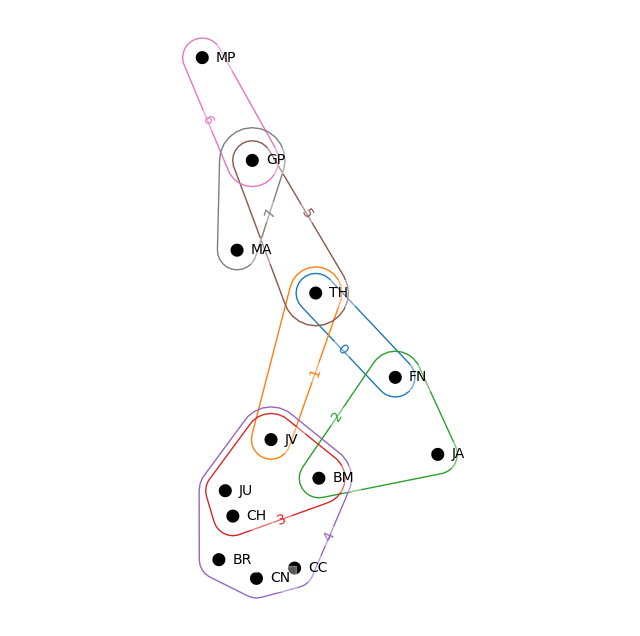

In [3]:
hnx.drawing.draw(H)

We can also view the dual of this graph easily, using the `H.dual()` command.

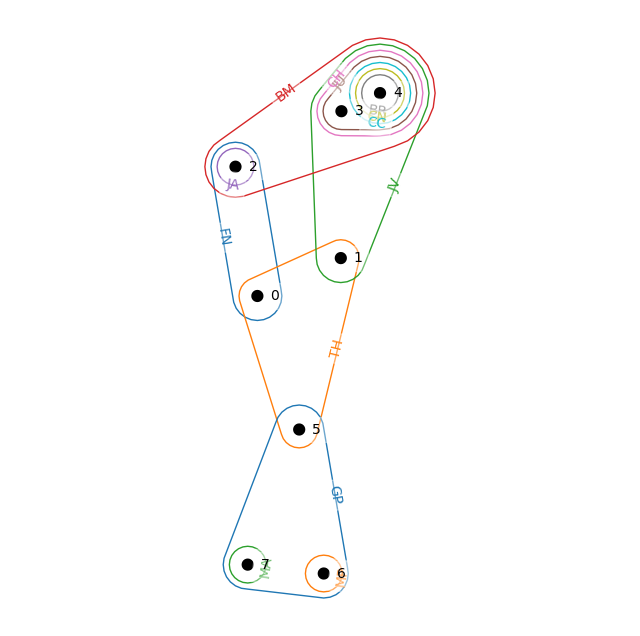

In [4]:
hnx.drawing.draw(H.dual())

# Basic Visualization Parameters
We will now explore some of the basic visualization parameters that are special for hypergraph visualization
* collapsing vertices and edges
* label options

## Collapsing Vertices
By passing in a hypergraph with its nodes collapsed (using `H.collapse_nodes()`), we show nodes with identical hyper edge membership to be collapsed into a single dot. The drawing tool automatically detects if nodes and edges have been collapsed, and the dot is labeled with the list of nodes it represents. In this case, `{CN, CC, BR}` and `{CH, JU}` were collapsed. The size of the dot increases to reflect the number of members. We pass `with_node_counts=True` to show  the number of nodes in the collapsed node instead of its label.

## A note on random seeds
We will use a consistent random seed across the next few diagrams to make the layout consistent. This is done by passing an arbitrary integer `{'seed': 39}` to the layout algorithm. The default layout algorithm is `nx.spring_layout` which takes a `seed` parameter which determines the inital random positioning of the vertices. Thus, `39` is passed into this function for that parameter to make the initial position (and final position) consistent each time the cell is executed.

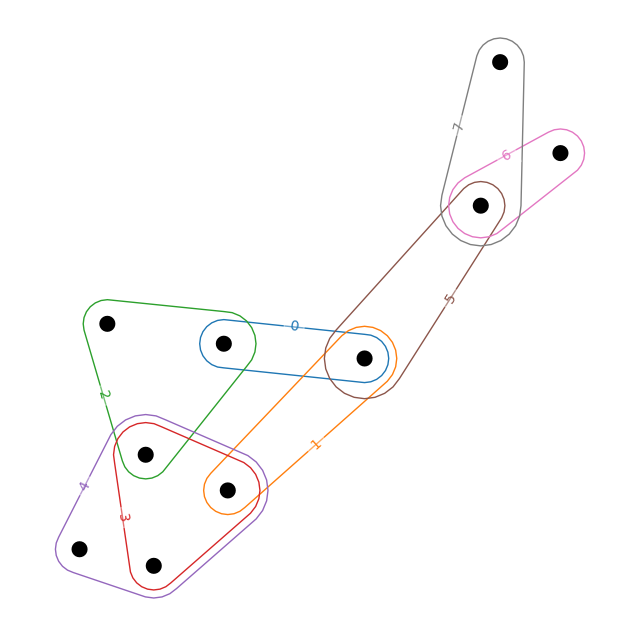

In [5]:
kwargs = {'layout_kwargs': {'seed': 39}, 'with_node_counts': True}

hnx.drawing.draw(H.collapse_nodes(), **kwargs)

## Label options
For anything but trivially small hypergraphs, the number of items in a collapsed element can be large, causing the label to be very long. You can set `with_node_counts=True` to mitigate this. This will replae node labels with counts where there is more than one element at that node.

The collapsed nodes from above have been replaced with `x3` and `x2`, and the rest of the labels have disappeared.

Similarly, hyperedges can be collapsed and relabeled. We will use the dual to illustrate this.

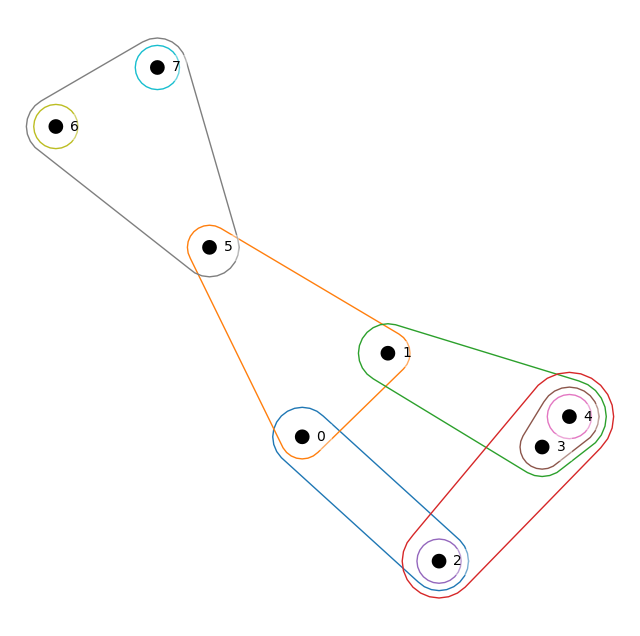

In [6]:
hnx.drawing.draw(H.dual().collapse_edges(), with_edge_counts=True)

## Disabling labels
If edge or node lables are a distraction, they can be turned off completely by passing in `with_edge_labels=False` or `with_node_labels=False`

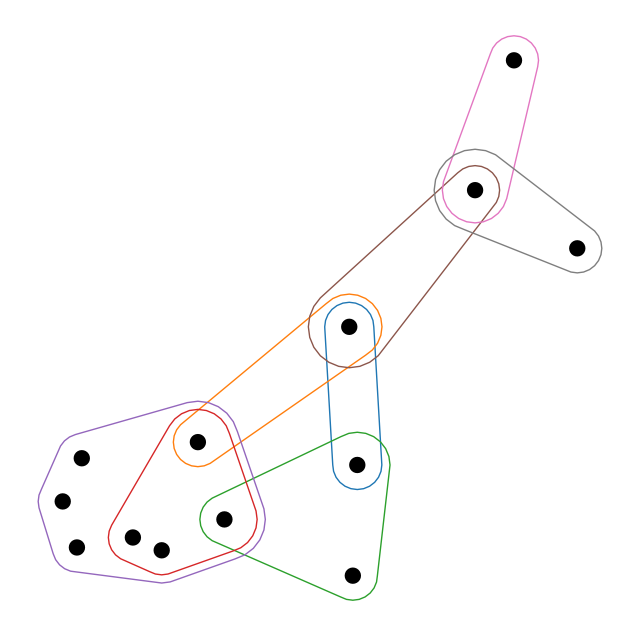

In [7]:
hnx.drawing.draw(H, with_edge_labels=False, with_node_labels=False)

## Advanced Visualization Parameters
Properties like colors and thickness can be adjusted. This allows style parameters to be passed directly to the corresponding Matplotlib function. The mapping is as follows:
* `edges_kwargs` => `matplotlib.collections.PolyCollection`
* `nodes_kwargs` => `matplotlib.collections.PolyCollection`
* `edge_labels_kwargs` => `matplotlib.annotate`
* `node_labels_kwargs` => `matplotlib.annotate`

## Colors
By default, we cycle through one of 10 unique colors for edges. This can be overridden using the `edges_kwargs` parameter. Here we adjust the linewidth, edge color, and face color.

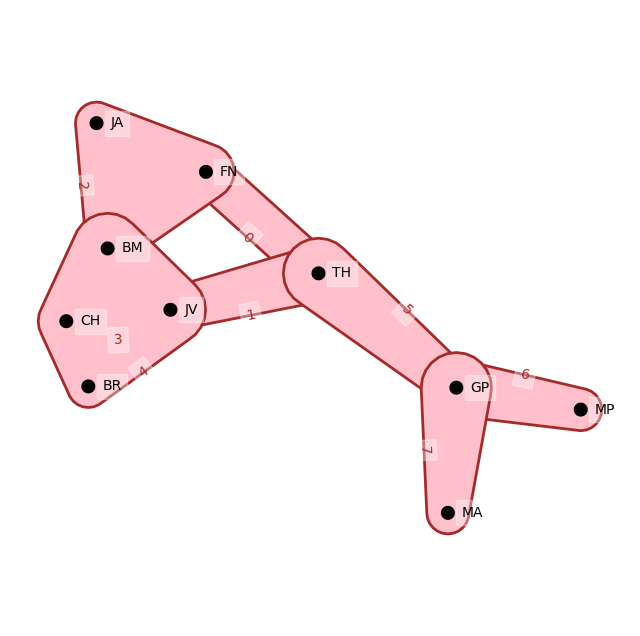

In [8]:
hnx.drawing.draw(H.collapse_nodes(),
    edges_kwargs={
        'linewidths': 2,
        'edgecolors': 'brown',
        'facecolors': 'pink'
    },
)

## Node colors
Pass an array of matplotlib colors to configure the individual colors of each node. The order of the array corresponds to the order returned by `H.__iter__()`.

In this example, we color the collapsed nodes red that are larger than 1 node:

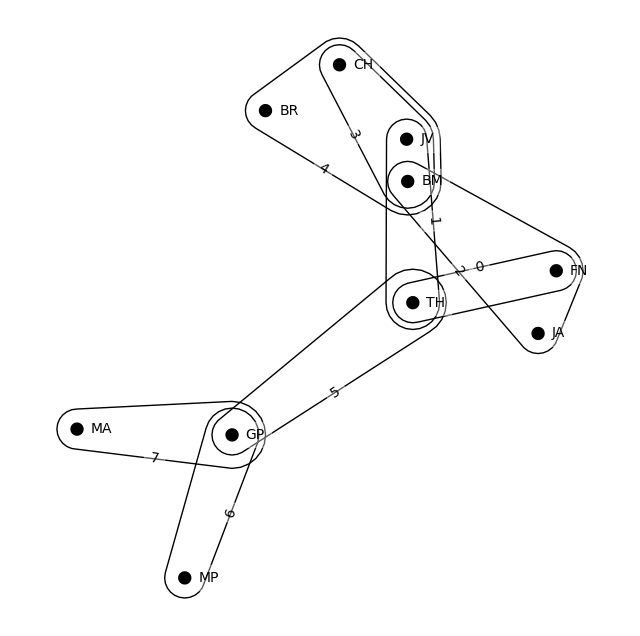

In [9]:
from hypernetx.drawing.util import get_collapsed_size
H_collapsed = H.collapse_nodes()

colors = [
    'red' if get_collapsed_size(v) > 1 else 'black'
    for v in H_collapsed
]

hnx.drawing.draw(
    H_collapsed,
    edges_kwargs={
     'edgecolors': 'black'
    },
    nodes_kwargs={
     'facecolors': colors
    }
)

## Edge colors
Pass an array of matplotlib colors to configure the individual colors of each edge. The order of the array corresponds to the order returned by `H.edges()`.

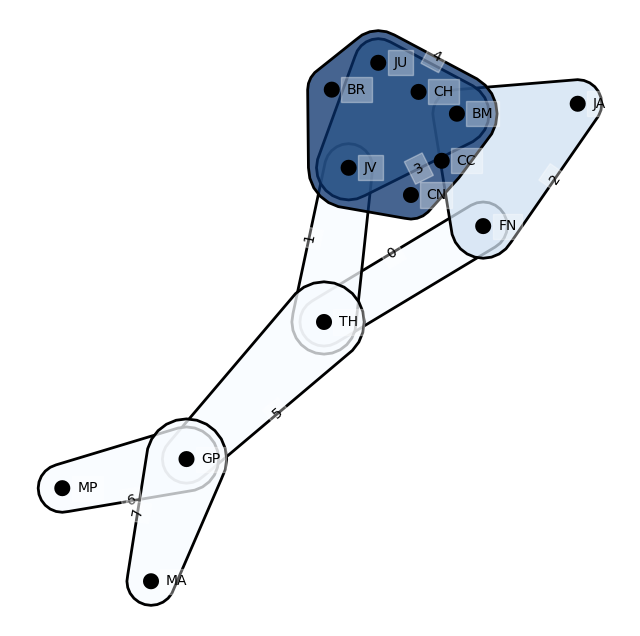

In [10]:
cmap = plt.cm.Blues
alpha = .75

sizes = np.array([H.size(e) for e in H.edges()])
norm = plt.Normalize(sizes.min(), sizes.max())

hnx.drawing.draw(H,
    edges_kwargs={
        'facecolors': cmap(norm(sizes))*(1, 1, 1, alpha),
        'edgecolors': 'black',
        'linewidths': 2
    }
)

## Font
Fontsize and other attributes can be set with the `node_labels_kwargs` and `edge_labels_kwargs` parameters. Here we set the font size at 24 to make the nodes appear large for illustrative purposes.

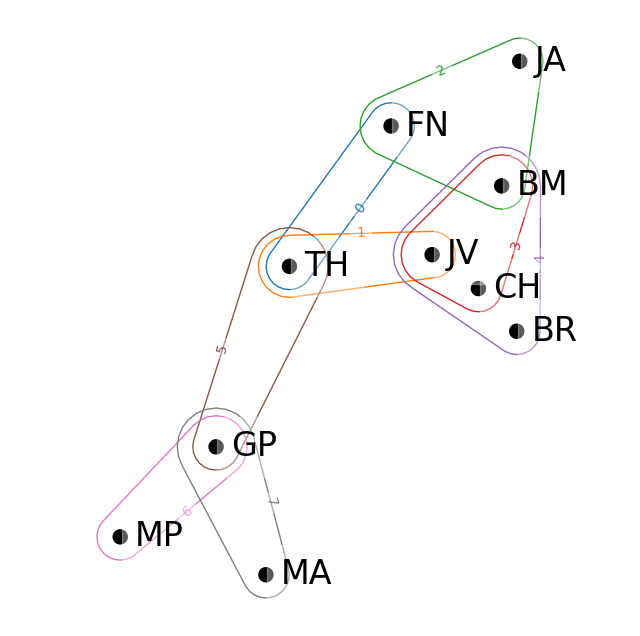

In [11]:
hnx.drawing.draw(H.collapse_nodes(),
    node_labels_kwargs={
        'fontsize': 24
    }
)

Font attributes can be individually set by passing in a dictionary mapping nodes to values

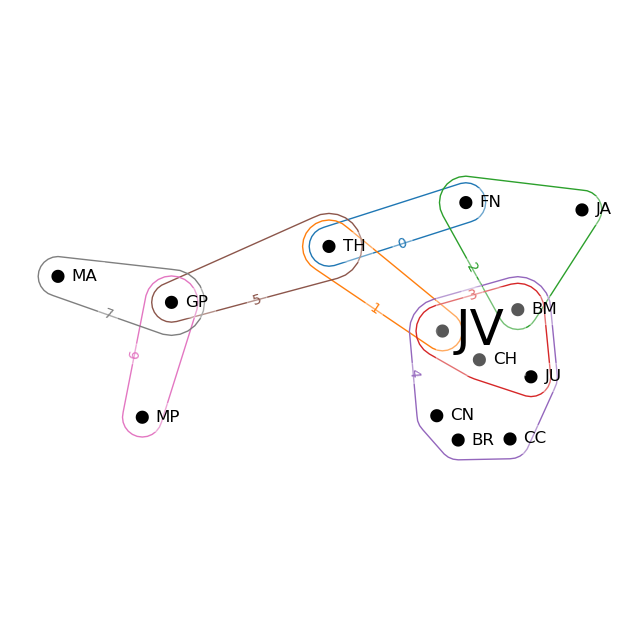

In [12]:
hnx.drawing.draw(H,
    node_labels_kwargs={
        'fontsize': {
            v: 36 if v == 'JV' else 12 for v in H
        }
    }
)

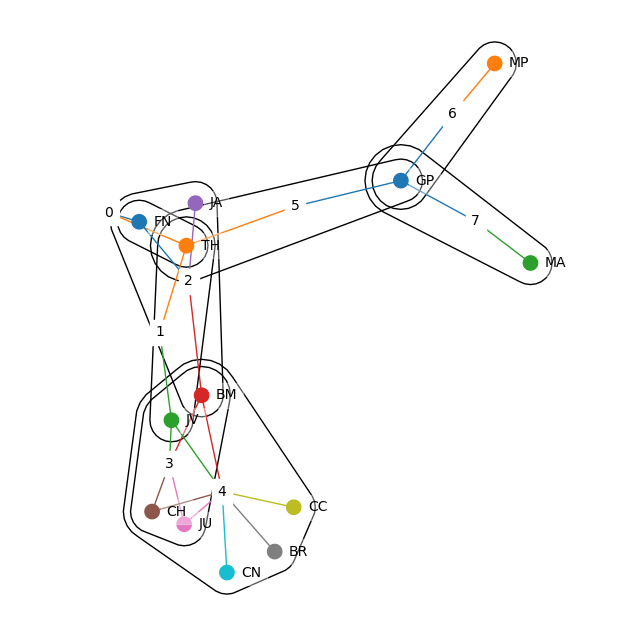

In [13]:
scenes = {
    0: ('FN', 'TH'),
    1: ('TH', 'JV'),
    2: ('BM', 'FN', 'JA'),
    3: ('JV', 'JU', 'CH', 'BM'),
    4: ('JU', 'CH', 'BR', 'CN', 'CC', 'JV', 'BM'),
    5: ('TH', 'GP'),
    6: ('GP', 'MP'),
    7: ('MA', 'GP')
}

H = hnx.Hypergraph(scenes)

colors = defaultdict(lambda: plt.cm.tab10(len(colors)%10))

def get_node_color(v):
    return colors[v]

def get_cell_color(e):
    return get_node_color(e[1])

hnx.draw(
    H,
    with_additional_edges=H.bipartite(),
    edges_kwargs={'edgecolors': 'black'},
    nodes_kwargs={'color': get_node_color},
    additional_edges_kwargs={'edge_color': get_cell_color},
    edge_labels_on_edge=False, edge_label_alpha=1
)

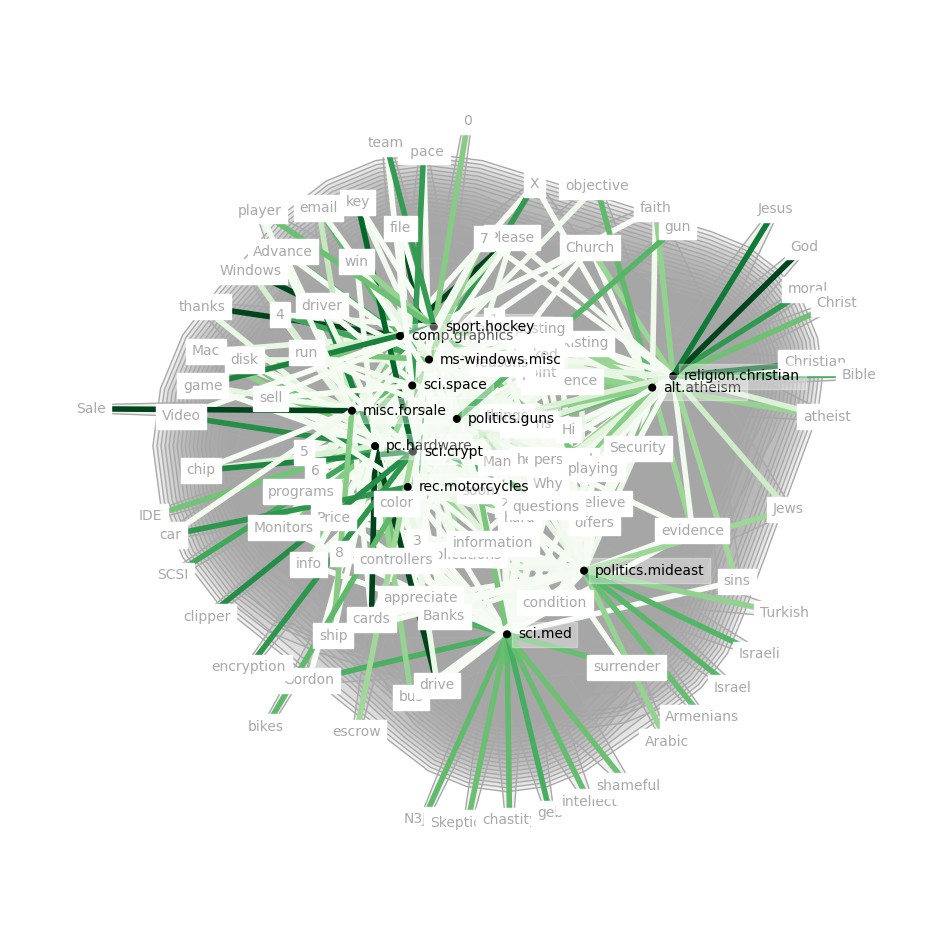

In [14]:


df = pd.read_csv('../data/newsgroups-topics.csv', index_col=0)
df.index = df.index.map(lambda s: '.'.join(s.split('.')[-2:]))

H = hnx.Hypergraph.from_incidence_dataframe(df)
# create functions for mapping hyper edges/weights to colors
norm = plt.Normalize(0, H.incidence_matrix().max().max())
cmap = plt.cm.Greens

def get_cell_color(e):
    return cmap(norm(H.incidences[e].weight))

plt.figure(figsize=(12, 12))
hnx.draw(
    H,
    layout=nx.kamada_kawai_layout,
    with_additional_edges=H.bipartite(),
    edges_kwargs={
        'edgecolors': 'darkgray',
        'facecolors': (.65, .65, .65, .15)
    },
    additional_edges_kwargs={
        'edge_color': get_cell_color,
        'width': 4,
    },
    edge_labels_on_edge=False, edge_label_alpha=1,
    contain_hyper_edges=True
)

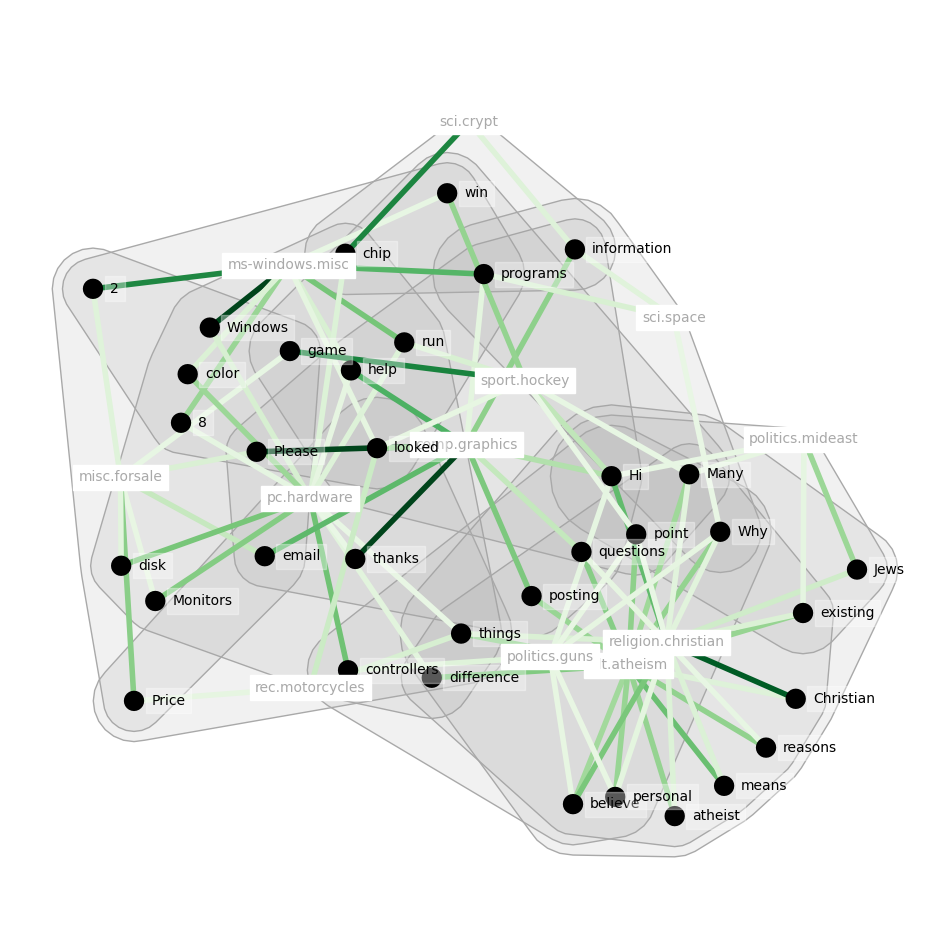

In [15]:
threshold = 0.1

# filter out singletons
newdf = df[df.columns[(df >= threshold).sum(axis=0) > 1]]

# filter out small weights
newdf[newdf < threshold] = None

# construct hypergraph
H2 = hnx.Hypergraph.from_incidence_dataframe(newdf.T)
norm = plt.Normalize(0, H2.incidence_matrix().max().max())
cmap = plt.cm.Greens

def get_cell_color(e):
    return cmap(norm(H2.incidences[e].weight))

plt.figure(figsize=(12, 12))
hnx.draw(
    H2,
    layout=nx.kamada_kawai_layout,
    with_additional_edges=H2.bipartite(),
    edges_kwargs={
        'edgecolors': 'darkgray',
        'facecolors': (.65, .65, .65, .15)
    },
    additional_edges_kwargs={
        'edge_color': get_cell_color,
        'width': 4,
    },
    edge_labels_on_edge=False, edge_label_alpha=1,
    contain_hyper_edges=True
)